# ANALYSIS OF ONE GRAPH USING QAOA CIRCUIT 

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, circuit_drawer, plot_state_qsphere
from qiskit_aer import AerSimulator
from qiskit_aer.noise import pauli_error, NoiseModel, depolarizing_error
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector, Kraus, SuperOp
from qiskit_ibm_runtime import SamplerV2
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import Pauli

In [2]:
import networkx as nx

In [3]:
from qiskit.circuit import ParameterVector

In [4]:
import matplotlib.pyplot as plt

In [5]:
graph = nx.erdos_renyi_graph(8, 0.5)

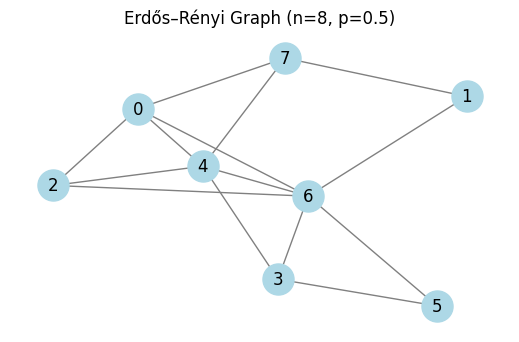

In [6]:
plt.figure(figsize=(5, 3))
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.title("Erdős–Rényi Graph (n=8, p=0.5)")
plt.show()

In [7]:
def create_qaoa_circuit(p, n, G):
    
    gamma = ParameterVector('γ',p)
    beta = ParameterVector('β',p)
    
    qc = QuantumCircuit(n, name='q')
    qc.h(range(n)) #superposition
    
    for i in range(p):
        for edge in G.edges(): #problem hamiltonian
            qc.rzz(gamma[i], edge[0], edge[1])
        for qubit in range(n): #mixer Hamiltonian
            qc.rx(2 * beta[i], qubit)
        if i != p-1:
            qc.barrier()
    return qc

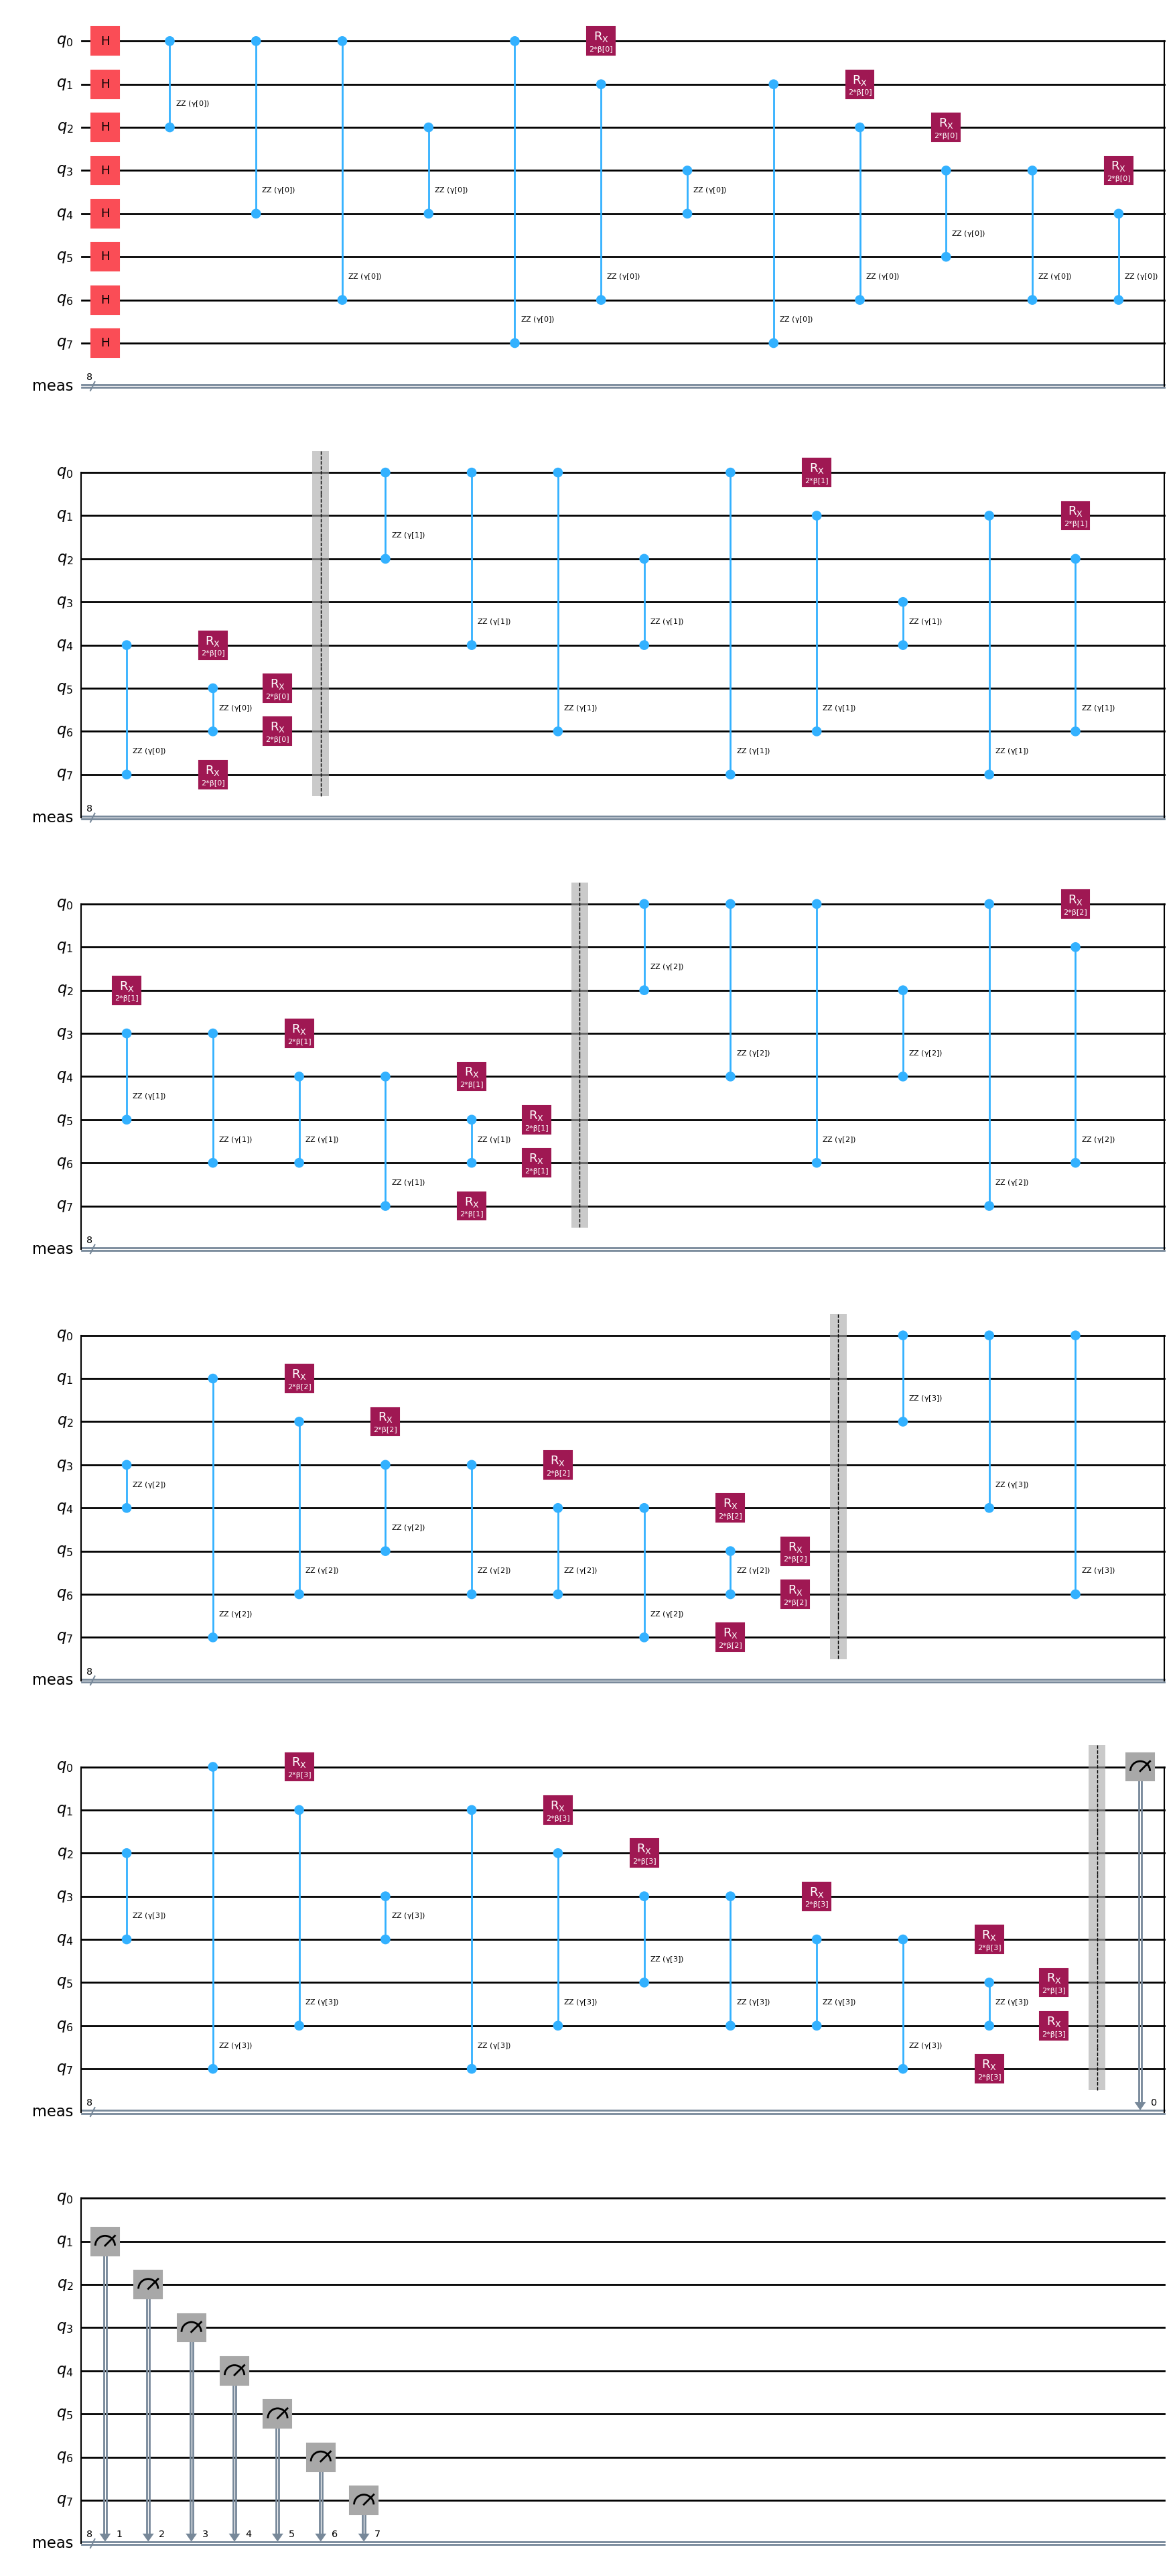

In [8]:
qaoa = create_qaoa_circuit(4, 8, graph)
qaoa.measure_all()
qaoa.draw('mpl')

In [9]:
from qiskit.quantum_info import SparsePauliOp

In [10]:
arr = []
for edge in graph.edges():
    str = 'IIIIIIII'
    s_list = list(str)
    s_list[edge[0]]='Z'
    s_list[edge[1]]='Z'
    new_string = ''.join(s_list)
    arr.append(new_string)

In [11]:
observables=[]
for i in arr:
    observables.append(SparsePauliOp(i))

In [12]:
observables

[SparsePauliOp(['ZIZIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZIIIZIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZIIIIIZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZIIIIIIZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZIIIIZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZIIIIIZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZIZIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZIIIZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIZZIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIZIZII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIZIIZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIZIZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIZIIZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIIIIZZI'],
               coeffs=[1.+0.j])]

In [13]:
init_params = [0]*qaoa.num_parameters
init_params

[0, 0, 0, 0, 0, 0, 0, 0]

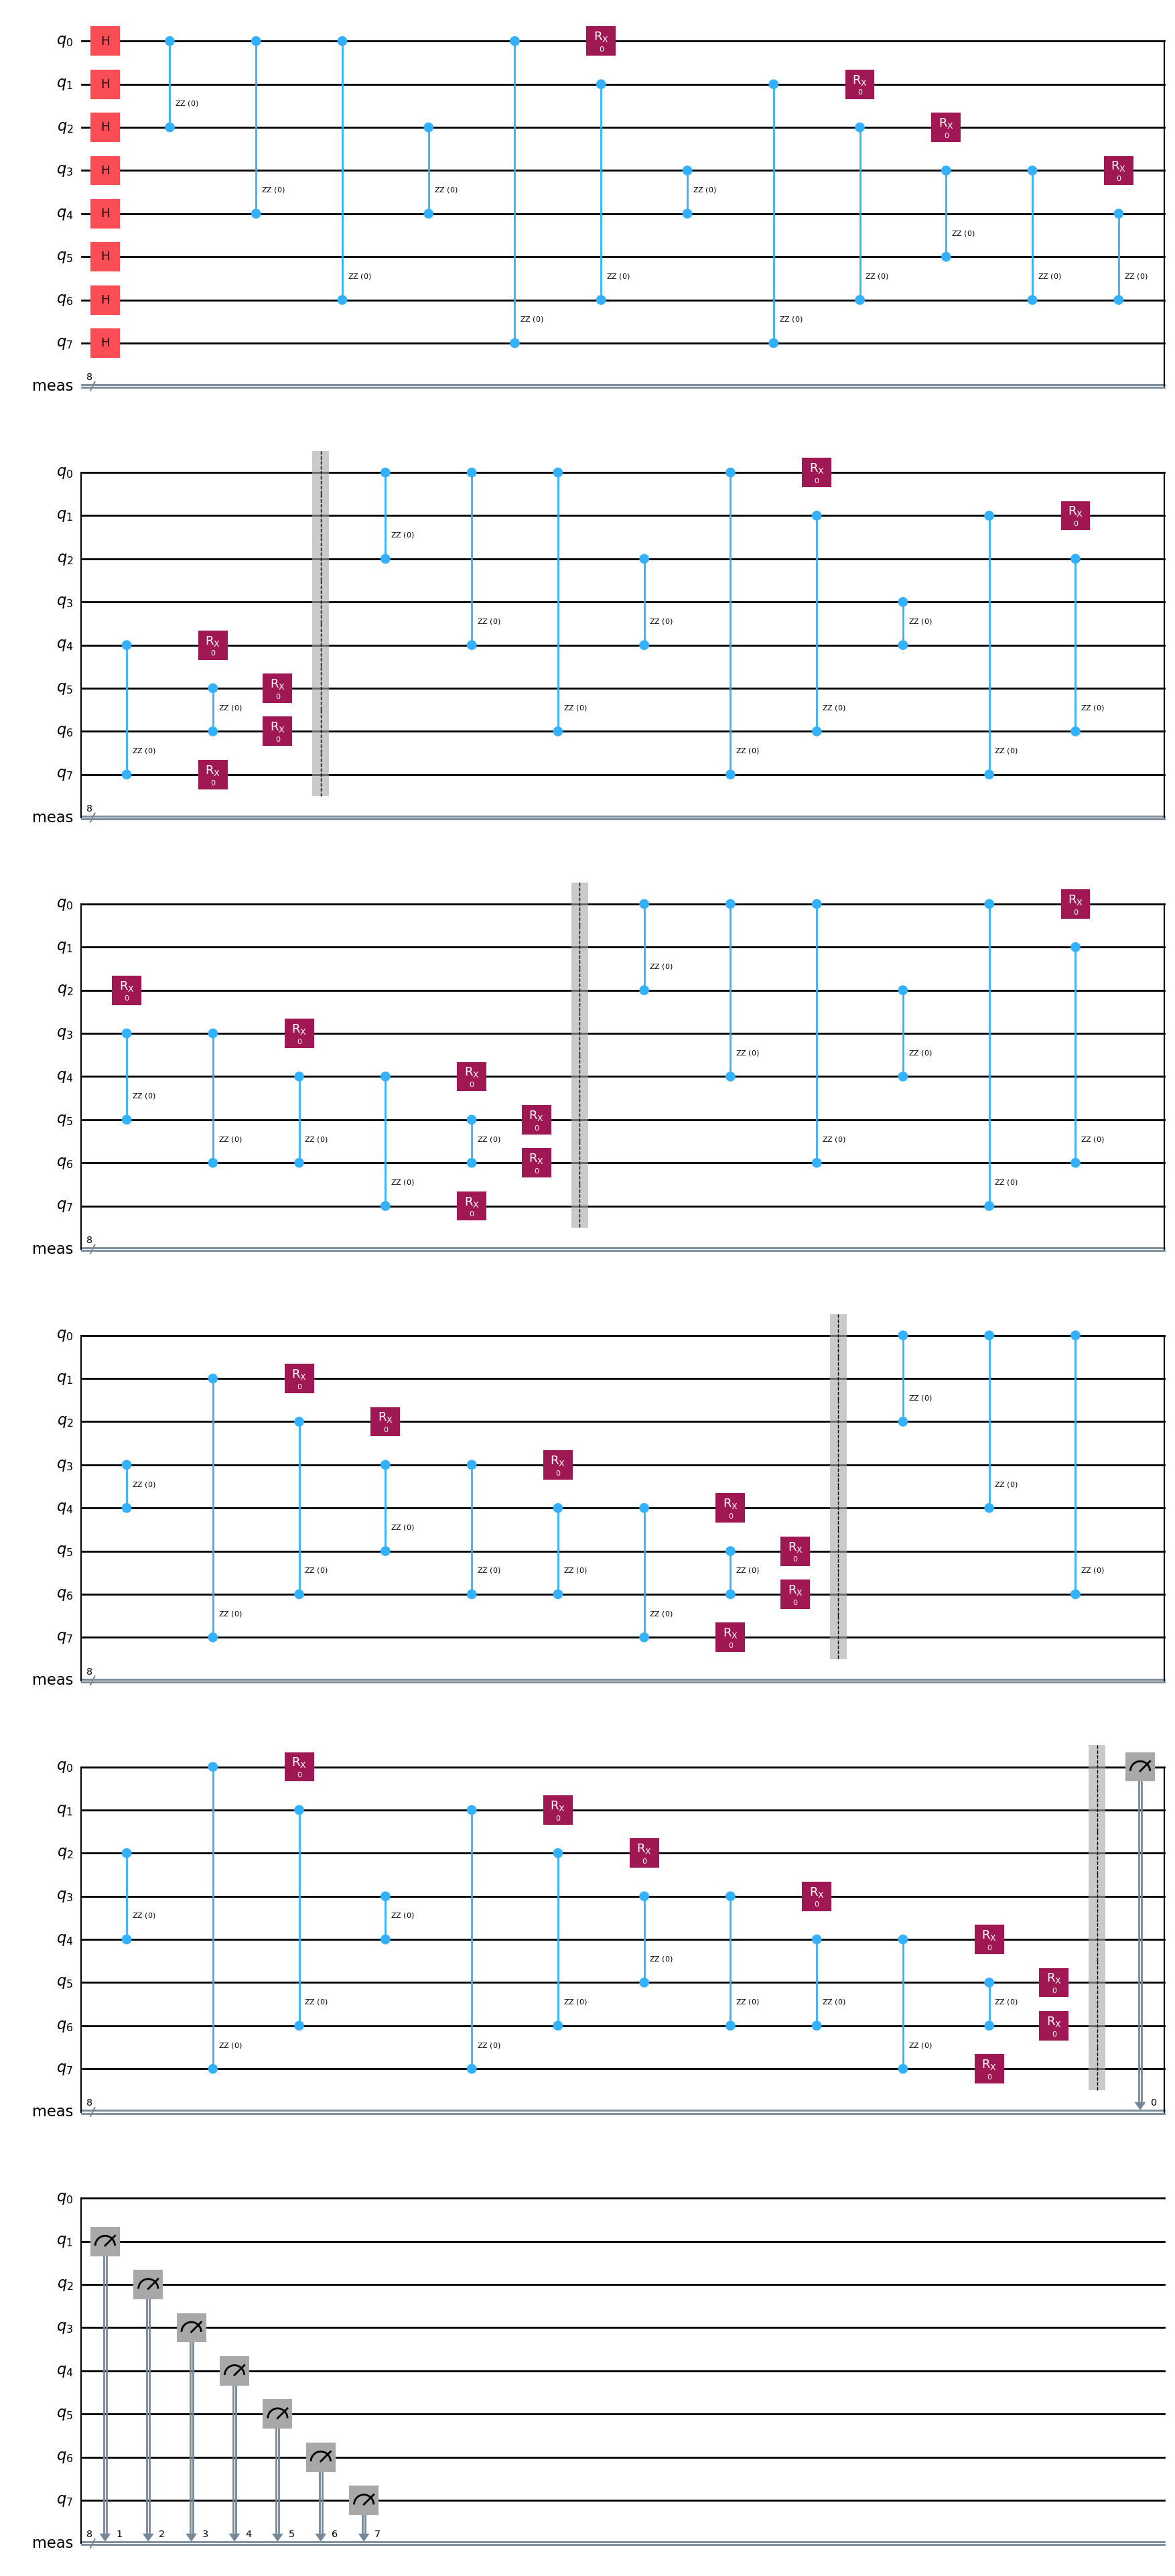

In [14]:
qaoa_params = qaoa.assign_parameters(init_params)
qaoa_params.draw('mpl')

In [15]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend=AerSimulator())

In [16]:
def obtain_expval(params: list, qaoa: QuantumCircuit, observables: list, estimator) -> float:
    # execute the circuit
    job = estimator.run([(qaoa, observables, params)])
    result = job.result()[0]

    # sum up values
    value = sum(result.data.evs)

    return value

In [17]:
from scipy.optimize import minimize

ideal_res = minimize(
    obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="cobyla"
)

init_params are the initial parameters, we have to find the initial parameters using ML so that <br>
the circuit converges quickly

In [18]:
ideal_res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.4345703125
       x: [ 7.700e-01  8.745e-01  2.441e-01  9.898e-01  9.670e-01
           -4.756e-01 -5.813e-01  2.110e-01]
    nfev: 111
   maxcv: 0.0

In [19]:
ideal_expval = ideal_res.fun

In [20]:
ideal_expval

-1.4345703125

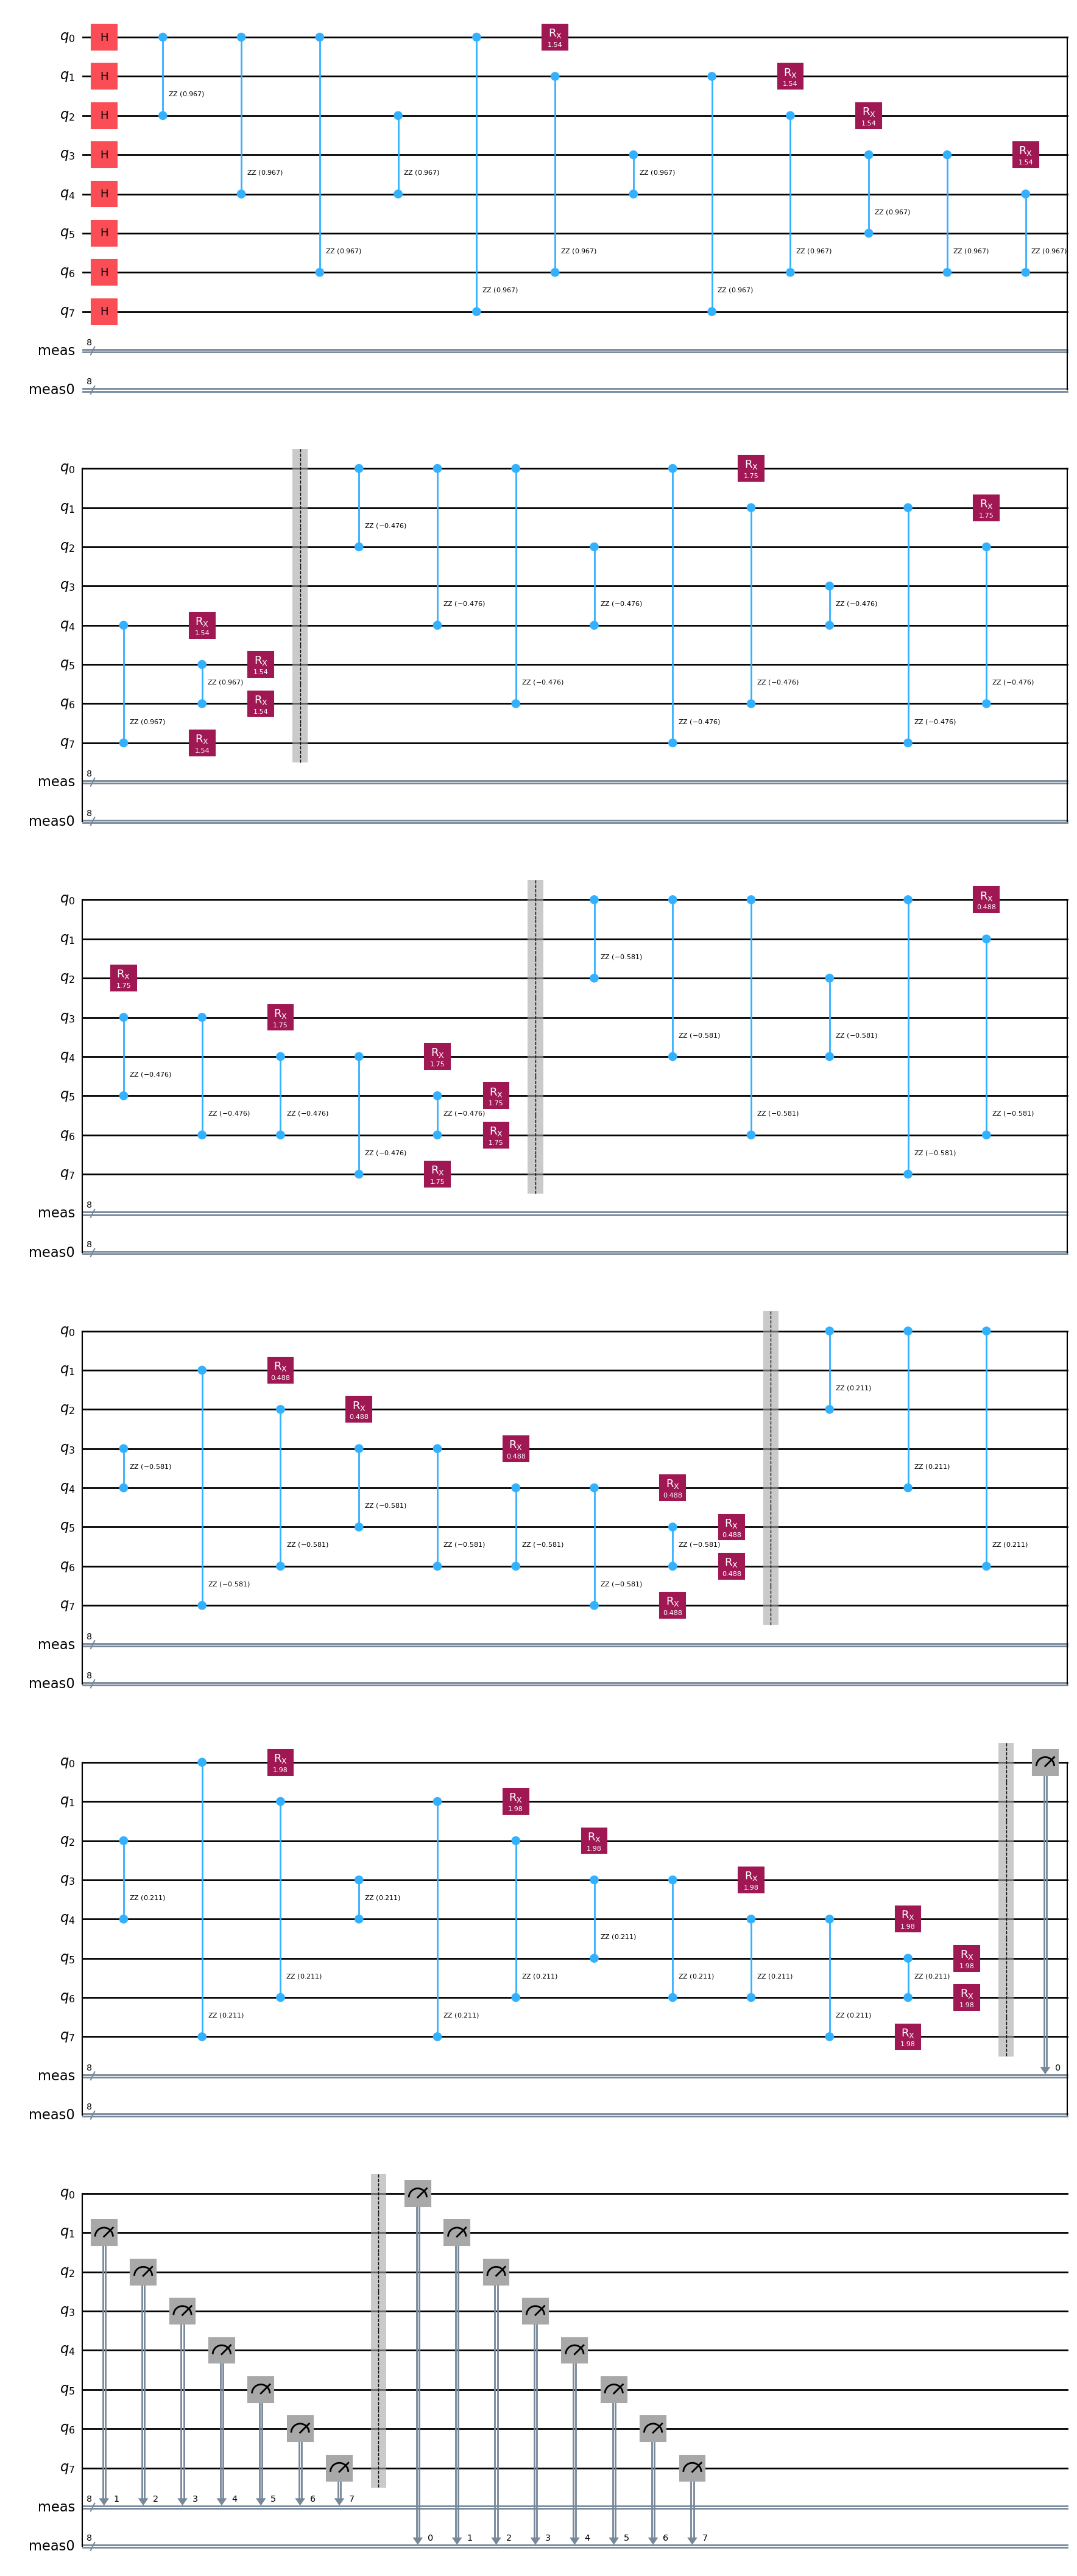

In [21]:
qaoa.assign_parameters(ideal_res.x, inplace=True)
qaoa.measure_all()
qaoa.draw('mpl')

In [22]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2

In [23]:
sampler = SamplerV2(backend=AerSimulator())
sampler.options.default_shots = 10000

In [24]:
job = sampler.run([qaoa])
result = job.result()[0]
counts = result.data.meas.get_counts()

In [27]:
bitstr = max(counts, key = counts.get)

In [28]:
bitstr

'11001100'

In [29]:
counts.get(bitstr)

567

In [30]:
part1, part2=[], []

In [32]:
for index in range(8):
    if(bitstr[index]=='0'):
        part1.append(index)
    else:
        part2.append(index)

In [33]:
part1, part2

([2, 3, 6, 7], [0, 1, 4, 5])